# Code to produce figure 6

### Zoïs Moitier (2021)
            
_Karlsruhe Institute of Technology, Germany_

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm

import scr
from scr import analytic, bie

%matplotlib inline

## Internal plotting functions

In [2]:
def calc_err(result, u_ana):
    return np.abs(result[0] - u_ana).max() / np.abs(u_ana).max()

In [3]:
def plot_err_2d(param):
    k = param["k"]

    M = param["M"]
    N = param["N"]

    α_vec = param["α_vec"]
    α_str = param["α_str"]

    ε_vec = param["ε_vec"]
    ε_str = param["ε_str"]

    err = np.empty((len(ε_vec), len(α_vec)))

    for i, ε in enumerate(ε_vec):
        E = scr.Ellipse(ε)
        c, ξ0 = analytic.ellipse_param(1, ε)

        for j, α in enumerate(α_vec):

            in_field = analytic.field_plane_wave(ε, c, α, k, M)
            sc_field = analytic.solve_field(in_field, ξ0, param["p"])

            θ, _ = bie.grid(N)
            u_ana = param["trace_ana"](in_field)(θ) + param["trace_ana"](sc_field)(θ)
            u_max = np.abs(u_ana).max()

            err[i, j] = calc_err(
                param["solver"](E, k, param["trace_input"](in_field), N), u_ana
            )

    fig_size = [1.25 * e for e in [6.4, 4.8]]
    fig, ax = plt.subplots(figsize=fig_size, constrained_layout=True)

    log_norm_err = LogNorm(err.min(), err.max())
    sns.heatmap(
        err,
        ax=ax,
        cmap="YlGnBu_r",
        norm=log_norm_err,
        xticklabels=α_str,
        yticklabels=ε_str,
    )
    ax.set_xlabel(r"$\alpha$", fontsize=15)
    ax.set_ylabel(r"$\varepsilon$", fontsize=15)
    ax.set_aspect("equal", "box")

    cbar_ax = fig.axes[-1]
    cbar_ax.tick_params(which="minor", length=0)

    plt.show()

    return None

In [4]:
def plot_angle(param):
    k = param["k"]

    m = param["m"]

    ε_min, ε_max = 1e-8, 0.9
    nb_ε = 16
    ε_vec = scr.logspace_epsilon(ε_max, ε_min, nb_ε)

    N = param["N"]

    err = np.zeros((nb_ε, len(param["angles"])))

    for j, α in enumerate(param["angles"]):
        for i, ε in enumerate(ε_vec):
            E = scr.Ellipse(ε)
            c, ξ0 = analytic.ellipse_param(1, ε)

            in_field = analytic.field_plane_wave(ε, c, α, k, m)
            sc_field = analytic.solve_field(in_field, ξ0, param["p"])

            θ, _ = bie.grid(N)
            u_ana = param["trace_ana"](in_field)(θ) + param["trace_ana"](sc_field)(θ)
            u_max = np.abs(u_ana).max()

            err[i, j] = calc_err(
                param["solver"](E, k, param["trace_input"](in_field), N), u_ana
            )

    fig_size = [1.25 * e for e in [6.4, 4.8]]
    fig, ax = plt.subplots(figsize=fig_size, constrained_layout=True)

    marker_vec = (".", "+", "*", "x")
    for n, leg in enumerate(param["angles_str"]):
        ax.loglog(ε_vec, err[:, n], f"{marker_vec[n]}--", lw=2, label=leg)

    if param["slope"][0]:
        ε_ = np.array([1e-8, 1e-3])
        ax.loglog(ε_, 10 ** (-1) * ε_, "k", label=r"$\mathcal{O}(\varepsilon)$")

    if param["slope"][1]:
        ε_ = np.array([1e-7, 1e-3])
        ax.loglog(
            ε_, 10 ** (-0.5) * ε_ ** 2, "k--", label=r"$\mathcal{O}(\varepsilon^2)$"
        )

    ax.set_xlim(1e-8 / 10 ** 0.5, 1 * 10 ** 0.5)
    ax.set_xlabel(r"$\varepsilon$", fontsize=15)
    ax.set_ylim(1e-16 / 10, 10)
    ax.set_ylabel("relative error", fontsize=15)
    ax.grid(True)
    ax.legend(loc=4, fontsize=15)

    ax.minorticks_off()

    plt.show()

    return None

## Parameters

In [5]:
## Incident field parameters
k = 2  # wavenumber direction of the plane wave
M = 15  # 2M+1 number of mode in the analytic sum

In [6]:
## Discretization parameters
N = 64  # Number of quadrature points

α_min, α_max = 16, 512
nb_α = 8
α_ = [f"{x:.2f}" for x in np.linspace(0, 0.5, num=nb_α)]
α_vec = [float(s) * np.pi for s in α_]
α_str = [fr"${s}\pi$" for s in α_]

ε_min, ε_max = 1e-8, 0.9
nb_ε = 8
ε_vec = scr.logspace_epsilon(ε_min, ε_max, nb_ε)[::-1]
ε_str = [f"{x:.1e}" for x in ε_vec]

## Neuman boundary condition

### Heatmap of the relative error for different directions

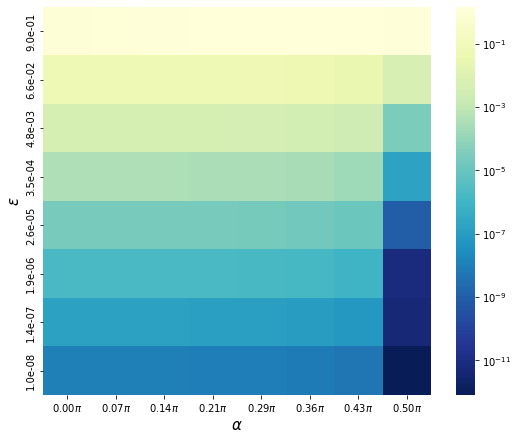

In [7]:
plot_err_2d(
    {
        "k": k,
        "M": M,
        "N": N,
        "α_vec": α_vec,
        "α_str": α_str,
        "ε_vec": ε_vec,
        "ε_str": ε_str,
        "p": 1,
        "trace_ana": scr.trace,
        "trace_input": scr.trace_neumann_expansion,
        "solver": bie.helmholtz_neumann_qpax,
    }
)

### Convergence plot of the relative error for different directions

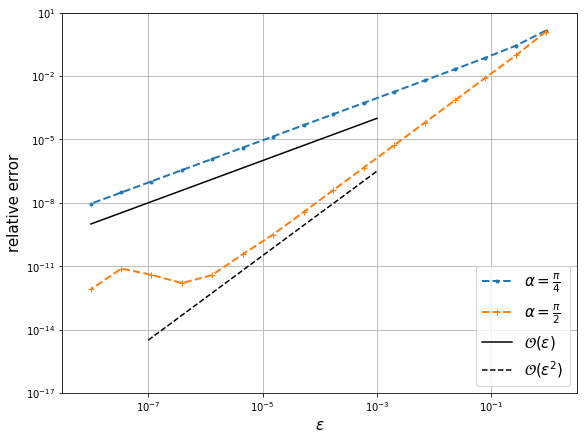

In [8]:
plot_angle(
    {
        "k": k,
        "m": 15,
        "angles": [np.pi / q for q in [4, 2]],
        "angles_str": [fr"$\alpha = \frac{{\pi}}{{{q}}}$" for q in [4, 2]],
        "N": 64,
        "trace_ana": scr.trace,
        "trace_input": scr.trace_neumann_expansion,
        "p": 1,
        "solver": bie.helmholtz_neumann_qpax,
        "slope": (True, True),
    }
)

## Dirichlet boundary condition

### Heatmap of the relative error for different directions

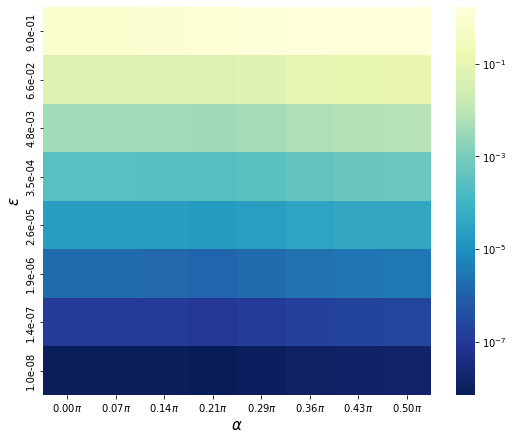

In [9]:
plot_err_2d(
    {
        "k": k,
        "M": M,
        "N": N,
        "α_vec": α_vec,
        "α_str": α_str,
        "ε_vec": ε_vec,
        "ε_str": ε_str,
        "p": 0,
        "trace_ana": scr.scaled_normal_trace,
        "trace_input": scr.trace_dirichlet_expansion,
        "solver": bie.helmholtz_dirichlet_qpax,
    }
)

### Convergence plot of the relative error for different directions

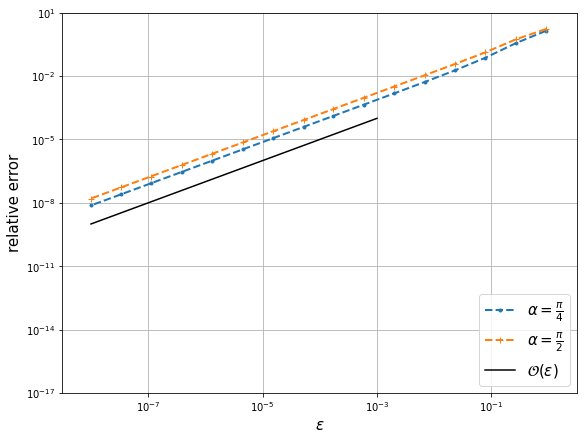

In [10]:
plot_angle(
    {
        "k": k,
        "m": 15,
        "angles": [np.pi / q for q in [4, 2]],
        "angles_str": [fr"$\alpha = \frac{{\pi}}{{{q}}}$" for q in [4, 2]],
        "N": 64,
        "trace_ana": scr.trace,
        "trace_ana": scr.scaled_normal_trace,
        "trace_input": scr.trace_dirichlet_expansion,
        "p": 0,
        "solver": bie.helmholtz_dirichlet_qpax,
        "slope": (True, False),
    }
)